# Independent Component Analysis

DataFun

Members:
Jan Botscch, Fabian Frank, David Munkacsi

In [1]:
import numpy as np
import scipy.io.wavfile as wav
from scipy.stats.stats import pearsonr 
import matplotlib.pyplot as plt
import pandas as pd

# 5.1 Initalization

a)

In [2]:
#defines
samplerate = 8192
N = 2
p = 18000

#load the data
dataSet1 = np.loadtxt('./sounds/sound1.dat')
dataSet2 = np.loadtxt('./sounds/sound2.dat')
s = np.stack([dataSet1, dataSet2], axis=0)
print (s.shape)

(2, 18000)


b)

In [3]:
# create random and invertible NxN (2x2) matrix
while True:
    A = np.random.rand(2,2)
    if np.linalg.det(A) != 0.0:
        break
print("A=" + str(A))

#mix the sources
x = np.matmul(A, s)

A=[[ 0.38280862  0.97489098]
 [ 0.7176313   0.17396155]]


c)

In [4]:
# remove temporal structure by permutation 
x_per = x[:, np.random.permutation(range(0,p))]


d)

In [5]:
#calculate correlation between sources and mixtures
corr_np = np.corrcoef(s,x_per)
print(corr_np)


[[ 1.          0.0012604  -0.0033784  -0.0063266 ]
 [ 0.0012604   1.          0.0048527   0.00563625]
 [-0.0033784   0.0048527   1.          0.57530785]
 [-0.0063266   0.00563625  0.57530785  1.        ]]


e)

In [6]:
#center the permuted data
mean = np.mean(x_per,axis=1, keepdims=True)
x_per_cent = x_per - mean;

#center the non-permuted data
x_cent = x - np.mean(x,axis=1, keepdims=True)

f)

In [7]:
#initialize W at random
while True:
    W_init = np.random.rand(2,2)
    if np.linalg.det(W_init) != 0.0:
        break
W_nat_init = np.copy(W_init)
print("W_init=" + str(W_init))

W_init=[[ 0.09901168  0.95717157]
 [ 0.84204031  0.12503066]]


# 5.2 Optimization

In [8]:
#function that calculates f''/f' 
def stepSigmoid(y):
	return 1 - 2 * (1 / (1 + np.exp(-y)))

#vectorize function
vStepSigmoid = np.vectorize(stepSigmoid)

def perform_ica(x, W, W_nat, eps=0.01):
#perform ica
#eps = 0.01
    convSpeed = np.empty([0,2])
    for i in range(0,p):
        #normal gradient
        dW = np.linalg.inv(W).T + np.outer(vStepSigmoid(np.dot(W,x_per_cent[:,i])),x_per_cent[:,i])
        W = W + eps * dW
        #natural gradient
        unmixed = np.dot(W_nat,x_per_cent[:,i])
        dW_nat = np.dot(x_per_cent[:,i] * np.eye(N) + np.dot(vStepSigmoid(unmixed),unmixed.T ), W_nat)
    
        if (i % 1000 == 0):
            convSpeed = np.vstack((convSpeed, [np.sum(W**2), np.sum(W_nat**2)]))
            
    return (W, W_nat, convSpeed)

W, W_nat, convSpeed = perform_ica(x_per, W_init, W_nat_init)
    
print("W final=" + str(W))
print("W_nat final=" + str(W_nat))
print('ConvSpeed: ', convSpeed.shape)

# get the unmixed signals
unmixedNormal = np.matmul(W, x_cent)
unmixedNatural = np.matmul(W_nat, x_cent)

W final=[[-0.67464312  3.38474617]
 [ 2.01506684 -1.13939753]]
W_nat final=[[ 0.09901168  0.95717157]
 [ 0.84204031  0.12503066]]
ConvSpeed:  (18, 2)


# 5.3 Results

(a) Plot and Play

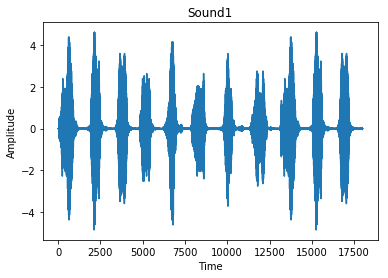

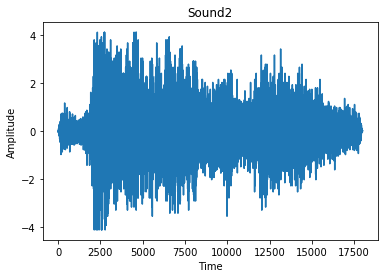

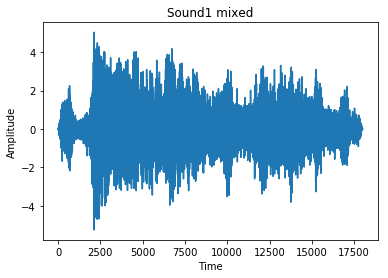

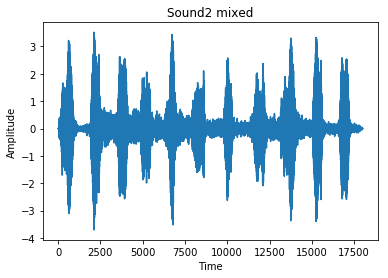

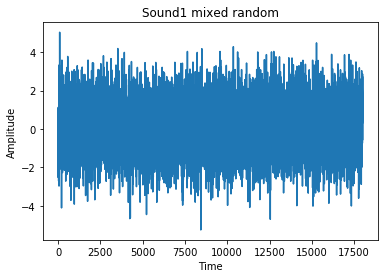

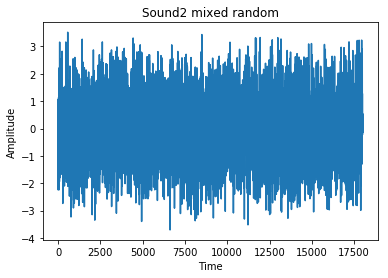

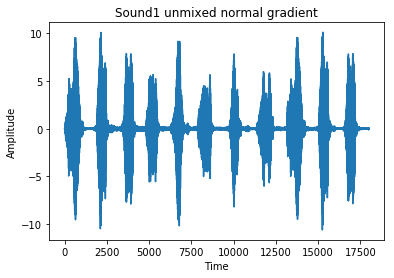

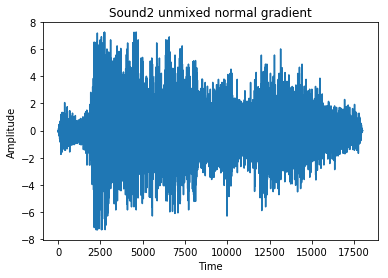

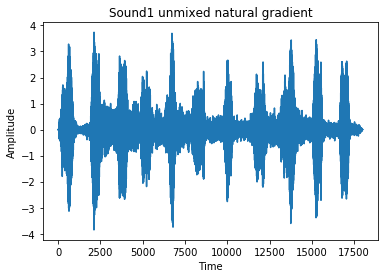

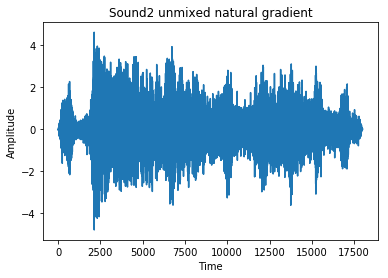

In [9]:
# Original sounds.
wav.write('Source1.wav',8192,dataSet1)
wav.write('Source2.wav',8192,dataSet2)

# Mixed sounds.
wav.write('Mixed1.wav',8192,x[0,:])
wav.write('Mixed2.wav',8192,x[1,:])

# Mixed and permutated.
wav.write('MixedPerm1.wav',8192,x_per[0,:])
wav.write('MixedPerm2.wav',8192,x_per[1,:])

# Unmixed with normal gradient.
wav.write('UnmixedNormGrad1.wav',8192,unmixedNormal[0,:])
wav.write('UnmixedNormGrad2.wav',8192,unmixedNormal[1,:])

# Unmixed with natural gradient.
wav.write('UnmixedNatGrad1.wav',8192,unmixedNatural[0,:])
wav.write('UnmixedNatGrad2.wav',8192,unmixedNatural[1,:])

plt.figure()
plt.plot(dataSet1)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1')

plt.figure()
plt.plot(dataSet2)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2')

plt.figure()
plt.plot(x[0,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1 mixed')
plt.figure()
plt.plot(x[1,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2 mixed')

plt.figure()
plt.plot(x_per[0,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1 mixed random')
plt.figure()
plt.plot(x_per[1,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2 mixed random')

plt.figure()
plt.plot(unmixedNormal[0,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1 unmixed normal gradient')
plt.figure()
plt.plot(unmixedNormal[1,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2 unmixed normal gradient')

plt.figure()
plt.plot(unmixedNatural[0,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound1 unmixed natural gradient')
plt.figure()
plt.plot(unmixedNatural[1,:])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound2 unmixed natural gradient')

plt.show()

(b) Calculate correlations between the true sources and the estimations

In [10]:
corrRecNorm = np.corrcoef(s,unmixedNormal)
corrRecNat = np.corrcoef(s,unmixedNatural)
print('Correlation unmixedNormal: ', corrRecNorm)
print('Correlation unmixedNatural: ', corrRecNat)

Correlation unmixedNormal:  [[ 1.          0.0012604   0.99949648 -0.0249274 ]
 [ 0.0012604   1.         -0.03046998  0.99965705]
 [ 0.99949648 -0.03046998  1.         -0.05663476]
 [-0.0249274   0.99965705 -0.05663476  1.        ]]
Correlation unmixedNatural:  [[ 1.          0.0012604   0.9400289   0.44010447]
 [ 0.0012604   1.          0.34227934  0.89850057]
 [ 0.9400289   0.34227934  1.          0.71999583]
 [ 0.44010447  0.89850057  0.71999583  1.        ]]


(c) Comparing learning speed, data whitening

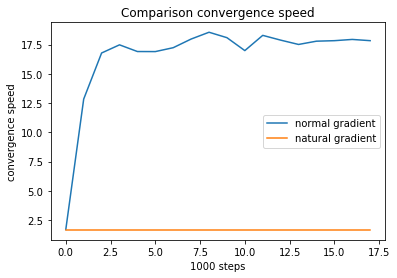

In [11]:
plt.figure()
norm_label, = plt.plot(convSpeed[:,0], label='normal gradient')
nat_label, = plt.plot(convSpeed[:,1], label='natural gradient')
plt.xlabel('1000 steps')
plt.ylabel('convergence speed')
plt.title('Comparison convergence speed')
plt.legend(handles=[norm_label, nat_label])
plt.show()

The convergence speed for normal gradient is higher than for natural gradient, and it seems to reaches a plateau and stay at this level after a reasonable number of steps.
The natural gradient is similar, but has more variance than normal gradient.

Whitening:

[[ 1.09535172  0.44411018]
 [ 0.44411018  0.54403552]]
(2, 18000)


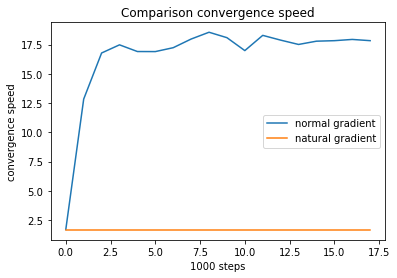

In [12]:
cov = np.cov(x_per)
print(cov)
eigval, eigvec = np.linalg.eig(cov)
Lambda = np.diag(1/np.sqrt(eigval))
x_white = (x_per.T @ eigvec @ Lambda).T
print(x_white.shape)

W_w, W_nat_w, convSpeed_w = perform_ica(x_white, W_init, W_nat_init)

plt.figure()
norm_label_w, = plt.plot(convSpeed_w[:,0], label='normal gradient')
nat_label_w, = plt.plot(convSpeed_w[:,1], label='natural gradient')
plt.xlabel('1000 steps')
plt.ylabel('convergence speed')
plt.title('Comparison convergence speed')
plt.legend(handles=[norm_label_w, nat_label_w])
plt.show()

The convergence speed for normal gradient is very similar as natural gradient.

(d) Plotting density

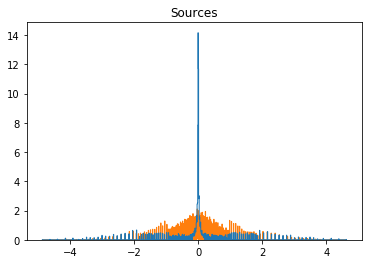

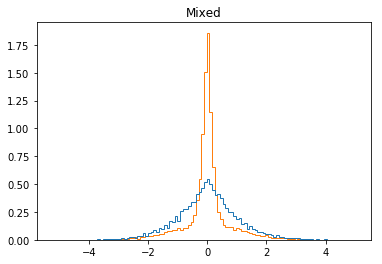

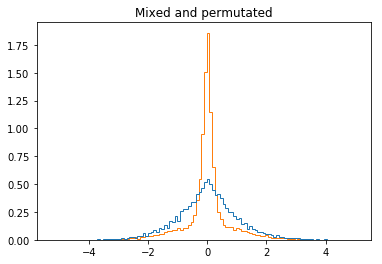

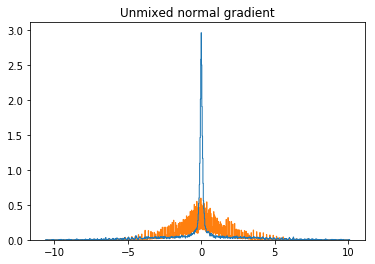

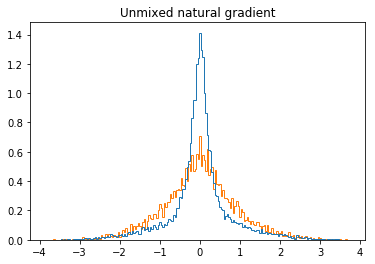

In [13]:
plt.figure()
h = plt.hist(s.T, bins='auto',normed=True,histtype = 'step')
plt.title('Sources')
plt.figure()
h = plt.hist(x.T, bins='auto',normed=True,histtype = 'step')
plt.title('Mixed')
plt.figure()
h = plt.hist(x_per.T, bins='auto',normed=True,histtype = 'step')
plt.title('Mixed and permutated')
plt.figure()
h = plt.hist(unmixedNormal.T, bins='auto',normed=True,histtype = 'step')
plt.title('Unmixed normal gradient')
plt.figure()
h = plt.hist(unmixedNatural.T, bins='auto',normed=True,histtype = 'step')
plt.title('Unmixed natural gradient')
plt.show()